# Sentiment analysis with RNN

In [2]:
import numpy as np
import scipy.sparse
import json
import zipfile as zip

import spacy
from keras.preprocessing import text, sequence
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser

import keras.backend as K
from keras.utils import to_categorical
from keras import models, optimizers, regularizers
from keras.layers import Dropout, Dense, Activation, Flatten, LSTM, Conv1D, Conv2D, MaxPooling1D, GRU, Embedding

from sklearn.model_selection import train_test_split

# Importing

Data is preprocessed as a list of lists, reviews are parsed and stop words and punctuation are removed.

In [3]:
with open('./processed/processed.txt', 'r') as f:
  restaurants = [json.loads(line) for line in f]

In [4]:
# different text cleaning for reviews
with open('./processed/reviews_cleaned.txt', 'r') as f:
  reviews = [json.loads(line) for line in f]

## Keras text processing example

In [5]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(['eat a lot, need to exercise more', "vegetables are good", "who likes chicken all the time"])


In [6]:
tokenizer.word_index

{'eat': 1,
 'a': 2,
 'lot': 3,
 'need': 4,
 'to': 5,
 'exercise': 6,
 'more': 7,
 'vegetables': 8,
 'are': 9,
 'good': 10,
 'who': 11,
 'likes': 12,
 'chicken': 13,
 'all': 14,
 'the': 15,
 'time': 16}

In [7]:
tokenizer.texts_to_sequences(['eat a lot', 'need to exercise more', 'chicken'])

[[1, 2, 3], [4, 5, 6, 7], [13]]

## Doing the same process with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [8]:
# create dictionary
# dict_yelp = corpora.Dictionary(reviews)

# # re-rerun after filtering dictionary
# corpus = [dict_yelp.doc2bow(review) for review in reviews]

# # save corpus
# corpora.MmCorpus.serialize('./processed/corpus.mm', corpus)

In [9]:
bow = False
if bow:
    # load corpus
    corpus = corpora.MmCorpus('./processed/corpus.mm')

In [10]:
# dict_yelp.save('./processed/dictionary')

In [11]:
dict_yelp = corpora.Dictionary.load('./processed/dictionary')

# tune corpus to get a smaller dictionary and doc_term matrix, embeddings will still work but bow will not fit into 8gb gpu memory otherwise
dict_yelp.filter_extremes(no_below=40, keep_n=20000)

In [12]:
# most common words
top_ids = sorted(dict_yelp.dfs.items(), key=lambda x: x[1], reverse=True)[0:30]
[(dict_yelp[item[0]], item[1]) for item in top_ids]

[('this', 240115),
 ('but', 234529),
 ('with', 212575),
 ('place', 204032),
 ('that', 201558),
 ('on', 194653),
 ('do', 176703),
 ('go', 167435),
 ('so', 159652),
 ('service', 155644),
 ('get', 152298),
 ('great', 151777),
 ('at', 146103),
 ('here', 139643),
 ('will', 131348),
 ('very', 126403),
 ('time', 124857),
 ('come', 122212),
 ('there', 121375),
 ('like', 119441),
 ('order', 117927),
 ('if', 115701),
 ('would', 115030),
 ('all', 113190),
 ('as', 112922),
 ('back', 110512),
 ('just', 109932),
 ('out', 109830),
 ('try', 102538),
 ('one', 101402)]

In [13]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys()) + 1
    
    for word in text:        
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_final)
    
    return processed[0:max_len]        

In [14]:
%%time
save = False
if save:
    
    corpus = [text_sequencer(dict_yelp, review) for review in reviews]
    corpus = sequence.pad_sequences(corpus, maxlen=200)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 13.8 µs


In [15]:
# this is the converted corpus array, not from gensim
if save:
    np.save('./processed/corpus.npy', corpus)
    
corpus = np.load('./processed/corpus.npy')

In [16]:
# # no sorting
# def data_split(data, proportion = .2):
#     cutoff = round(len(data) * (1-proportion))
#     return data[0:cutoff], data[cutoff:]
    

## Integrating glove embeddings

In [17]:
emb_path = '/projects/embeddings/data/'

In [18]:
def load_embeddings():
    # load glove vectors
    embeddings_index={}
    with zip.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(keys, dict_yelp):
    
    embeddings_index = load_embeddings()
    conversion_table = {}
    for key in keys:
        if bytes(key, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[key]+1] = embeddings_index[bytes(key, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[key]+1] = np.random.randn(100)
    return conversion_table

In [19]:
conversion_table = id_to_glove(dict_yelp.token2id.keys(), dict_yelp)
embedding_matrix = np.vstack([conversion_table[key] for key in conversion_table.keys()])
embedding_matrix = np.vstack((np.zeros(100), embedding_matrix, np.random.randn(100)))

## Compressed matrix creation

In [20]:
if bow:
    # skipped if not using bag-of-words or corpus fits into memory, uses gensim corpus object not list of lists
    matrix = corpus2csc(corpus, num_terms=len(dict_yelp.keys()), num_docs=490049, dtype=np.int16).T
    matrix = matrix.tocsr()
    matrix.shape
if save:
    scipy.sparse.save_npz('./processed/corpus_matrix', matrix)

# matrix = scipy.sparse.load_npz('./processed/corpus_matrix.npz')

## Labels

In [21]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    else:
        return 0

In [22]:
stars = np.array([restaurant['stars'] for restaurant in restaurants])
stars = [convert_rating(star) for star in stars]

In [23]:
with open('ratings.npy', 'rb') as f:
    stars = np.load(f, allow_pickle=False)


In [24]:
train, val, train_y, val_y = train_test_split(corpus, stars, test_size = 0.2)

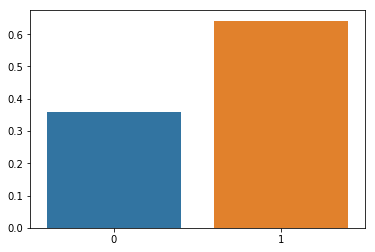

In [25]:
sns.barplot(x = stars, y = stars, estimator=lambda x: len(x)/len(stars))
plt.show()

## Generator function

In [26]:
# keras needs arrays as inputs, so .A reconverts a batch to the original numpy array

def get_batch(matrix, labels, bs):
    # matrix should be a document x word csr matrix
    i = 0
    while i < matrix.shape[0]/bs:
        yield matrix[i*bs:(i+1)*bs,].A, labels[i*bs:(i+1)*bs]
        i+=1  

In [27]:
if bow:
    generator = get_batch(matrix, stars, 32)
    review_lens = [len(review) for review in reviews]
    print(np.max(review_lens))
    print(np.min(review_lens))
    print(np.std(review_lens))
    print(np.median(review_lens))
    print(np.mean(review_lens))
    print(np.percentile(review_lens, 99.5))
    sns.distplot(review_lens)
    plt.show()

In [28]:
# originally written to cut review lengths, did this in gensim_walkthrough instead
def cut(review, cutoff=30):
    text = ''
    for i, word in enumerate(review):
        if i <= 30:
            if text == '':
                text = word
            else:    
                text += ' ' + word
    return text        

## Modeling 

In [29]:
# use if training for more categories
vocab_size = len(dict_yelp.keys())
assert corpus.shape == (490049, 200)
stars_cat = to_categorical(stars)

In [30]:
if save:
    with open('ratings.npy', 'wb') as f:
        np.save(f, stars)


In [31]:
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


In [32]:
# units for output size in Dense layer, vocab_size for number of features in nlp in Embedding 
# tried adding dropout but it lowered accuracy, shouldn't need it if it's not overfitting

model = models.Sequential()
model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
model.add(Conv1D(100, 5))
model.add(Conv1D(100, 3))
model.add(MaxPooling1D(4))
model.add(LSTM(67))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1258000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 100)          50100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 194, 100)          30100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 67)                45024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 68        
Total params: 1,383,292
Trainable params: 1,383,292
Non-trainable params: 0
_________________________________________________________________


## Training

In [33]:
model.fit(train, train_y, batch_size=32, epochs=2, verbose=1, validation_split=0.2)

Train on 313631 samples, validate on 78408 samples
Epoch 1/2
313631/313631 [==============================] - 728s 2ms/step - loss: 0.4535 - acc: 0.8495 - val_loss: 0.4198 - val_acc: 0.8516
Epoch 2/2
313631/313631 [==============================] - 730s 2ms/step - loss: 0.3917 - acc: 0.8591 - val_loss: 0.3860 - val_acc: 0.8587


In [34]:
# # reset weights if necessary
# model.reset_states()

In [35]:
# adjust lr since val loss increases, seems to be going past minimum
K.set_value(model.optimizer.lr, 0.0001)


In [36]:
model.fit(train, train_y, batch_size=32, epochs=1, verbose=1, validation_split=0.2)

Train on 313631 samples, validate on 78408 samples
Epoch 1/1
313631/313631 [==============================] - 724s 2ms/step - loss: 0.3667 - acc: 0.8676 - val_loss: 0.3685 - val_acc: 0.8653


In [37]:
if save:
    model.save('./models/lstm')

In [38]:
# from keras.models import load_model
# model = load_model('./models/test_ann')

/home/ryeyoo/anaconda3/envs/keras/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## Evaluation

In [39]:
model.evaluate(val, val_y, batch_size=32, verbose=1)

98010/98010 [==============================] - 48s 491us/step


[0.29986774626678014, 0.9011427405378962]

In [80]:


def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
    cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
    print('binary cross entropy is %.4f' % binary_cross_entropy)
    print('prob error is greater than 0.5 is %.4f' % cond_error)


/home/ryeyoo/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


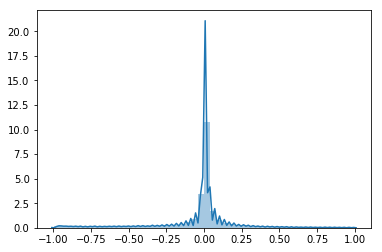

binary cross entropy is -0.2428
prob error is greater than 0.5 is 0.0989


In [86]:
evaluate(val, val_y)